## Postprocess SWAT Simulations (6) - Runoff Change With %SQL

We already introduced how to post-process SWAT simulation by SQLite and Pandas in previous [notebooks](https://www.linkedin.com/pulse/postprocess-swat-simulations-sqlite-pandas-1-runoff-chonghua-yin/), where the SWAT simulations are stored in SQLite databases.

In this notebook, we try to process the simulations using **ipython-sql**. That is to say, SQL from a notebooks, using magic commands to query a sqllite3 database. ipython-sql introduces a %sql (or %%sql) magic to your notebook allowing you to connect to a database, using SQLAlchemy connect strings, then issue SQL commands within IPython or IPython Notebook.

You can install it using **pip install ipython-sql** or **conda install ipython-sql**.

*It is worth noting that all data in this series are fake data and only are used to show how to post-process SWAT simulations through open source tools.*

## 1. Load all needed libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

## 2. Play ipython-sql

### 2.1 Load ipython-sql library

The ipython-sql library is loaded using the %load_ext iPython extension syntax. In addition, there are two kinds of magics line-oriented and cell-oriented prefaced with % and %% respectively.

In [2]:
%load_ext sql

### 2.2 Connect to the database

In [3]:
%sql sqlite:///data/baseline/result_664_monthly.db3

u'Connected: @data/baseline/result_664_monthly.db3'

### 2.3 Check tables

In [4]:
%sql SELECT name FROM sqlite_master WHERE type='table'

 * sqlite:///data/baseline/result_664_monthly.db3
Done.


name
rch
hru
sub
sed
watershed_daily
watershed_monthly
watershed_yearly
channel_dimension
hru_info
sub_info


### 2.4 Check table columns (i.e., header or fields)

In [5]:
%sql select * from rch where 1=0

 * sqlite:///data/baseline/result_664_monthly.db3
Done.


RCH,YR,MO,FLOW_INcms,FLOW_OUTcms,EVAPcms,TLOSScms,SED_INtons,SED_OUTtons,SEDCONCmg_kg,ORGN_INkg,ORGN_OUTkg,ORGP_INkg,ORGP_OUTkg,NO3_INkg,NO3_OUTkg,NH4_INkg,NH4_OUTkg,NO2_INkg,NO2_OUTkg,MINP_INkg,MINP_OUTkg,CHLA_INkg,CHLA_OUTkg,CBOD_INkg,CBOD_OUTkg,DISOX_INkg,DISOX_OUTkg,SOLPST_INmg,SOLPST_OUTmg,SORPST_INmg,SORPST_OUTmg,REACTPSTmg,VOLPSTmg,SETTLPSTmg,RESUSP_PSTmg,DIFFUSEPSTmg,REACBEDPSTmg,BURYPSTmg,BED_PSTmg,BACTP_OUTct,BACTLP_OUTct,CMETAL_1kg,CMETAL_2kg,CMETAL_3kg,TOT_Nkg,TOT_Pkg,NO3ConcMg_l,WTMPdegc


### 2.5 Query table

Take the **rch** table as example. We can put the query result into variable.

In [6]:
sqlres = %sql SELECT RCH, YR, MO, FLOW_OUTcms from rch LIMIT 5
sqlres

 * sqlite:///data/baseline/result_664_monthly.db3
Done.


RCH,YR,MO,FLOW_OUTcms
1,1981,1,146.252487183
2,1981,1,96.1828536987
3,1981,1,11.8613681793
4,1981,1,49.4065132141
5,1981,1,272.106018066


## 3. Process runoff

Two key steps: 
- (1) convert month to season
- (2) calculate seasonal mean

Therefore, a nested sql query is applied.

### 3.1 Baseline
**Connect to baseline db**

In [7]:
%sql sqlite:///data/baseline/result_664_monthly.db3

u'Connected: @data/baseline/result_664_monthly.db3'

** Calculate seasonal mean for each season**

In [8]:
%%sql BASE_SSN << 
SELECT RCH, Quarter, AVG(FLOW_OUTcms) as Runoff
FROM(
SELECT RCH, YR, 
CASE 
    WHEN (MO) BETWEEN 3 AND 5 THEN 'MAM'   
    WHEN (MO) BETWEEN 6 and 8 THEN 'JJA'
    WHEN (MO) BETWEEN 9 and 11 THEN 'SON'
    ELSE 'DJF' 
END Quarter,
FLOW_OUTcms
from rch)
GROUP BY RCH, Quarter

 * sqlite:///data/baseline/result_664_monthly.db3
Done.
Returning data to local variable BASE_SSN


### 3.2 Future
**Connect to future db**

In [9]:
%sql sqlite:///data/future/result_664_monthly.db3

u'Connected: @data/future/result_664_monthly.db3'

** Calculate seasonal mean for each season**

In [10]:
%%sql FUTU_SSN << 
SELECT RCH, Quarter, AVG(FLOW_OUTcms) as Runoff
FROM(
SELECT RCH, YR, 
CASE 
    WHEN (MO) BETWEEN 3 AND 5 THEN 'MAM'   
    WHEN (MO) BETWEEN 6 and 8 THEN 'JJA'
    WHEN (MO) BETWEEN 9 and 11 THEN 'SON'
    ELSE 'DJF' 
END Quarter,
FLOW_OUTcms
from rch)
GROUP BY RCH, Quarter

   sqlite:///data/baseline/result_664_monthly.db3
 * sqlite:///data/future/result_664_monthly.db3
Done.
Returning data to local variable FUTU_SSN


In [11]:
df = FUTU_SSN.DataFrame()
df.head()

,RCH,Quarter,Runoff
0,1,DJF,87.643939
1,1,JJA,1347.443983
2,1,MAM,713.695934
3,1,SON,384.962918
4,2,DJF,45.715684


### 3.3 Convert to DataFrame

To simplify other operations, convert sql-query results into pivoted table

In [12]:
def convert_pivoted(sql_ssn):
    ssndf = sql_ssn.DataFrame()
    ssndf.set_index(['RCH'])
    ssndf = ssndf.rename(index=str, columns={"level_1":"Quarter"})
    pivoted = ssndf.pivot(index='RCH', columns='Quarter', values='Runoff')
    return pivoted

In [13]:
pivoted_bsl = convert_pivoted(BASE_SSN)
pivoted_fut = convert_pivoted(FUTU_SSN)
print(pivoted_fut.head())
print(pivoted_bsl.head())

Quarter         DJF          JJA          MAM         SON
RCH                                                      
1         87.643939  1347.443983   713.695934  384.962918
2         45.715684   762.344993   281.216780  252.879492
3         54.120251   148.082089   378.022691   24.557090
4         22.645753   577.105851   361.976762  131.144510
5        346.533086  1555.323420  1360.550300  426.599176
Quarter         DJF          JJA          MAM         SON
RCH                                                      
1         99.204991  1405.262298   559.746932  454.737985
2         56.328539   773.664280   203.242828  297.934326
3         32.838328   166.310382   379.771358   27.425488
4         28.384519   619.184517   278.996801  155.766145
5        336.824441  1635.518864  1215.423962  499.265579


### 3.4 Calculate seasonal changes

In [14]:
pivoted_ch = (pivoted_fut - pivoted_bsl)/pivoted_bsl*100.0
pivoted_ch.head()

Quarter,DJF,JJA,MAM,SON
RCH,,,,
1,-11.653700,-4.114414,27.503322,-15.344016
2,-18.840992,-1.463075,38.364922,-15.122405
3,64.808181,-10.960406,-0.460453,-10.458876
4,-20.217946,-6.795820,29.742263,-15.806795
5,2.882405,-4.903364,11.940388,-14.554659


## 4. Visualize

Set some parameters to make figure pretty

Text(0,0.5,'Runoff Change (%)')

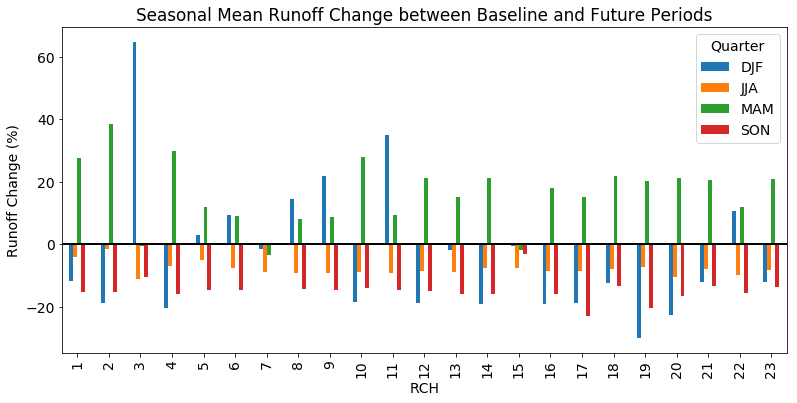

In [15]:
# Plot size to 15" x 7"
matplotlib.rc('figure', figsize = (13, 6))
# Font size to 14
matplotlib.rc('font', size = 14)
# Display top and right frame lines
matplotlib.rc('axes.spines', top = True, right = True)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')

ax = pivoted_ch.plot(kind='bar',                    
             title='Seasonal Mean Runoff Change between Baseline and Future Periods')
ax.axhline(y=0, xmin=-1, xmax=1, color='k', lw=2)
ax.set_ylabel('Runoff Change (%)')

## References

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010)

https://www.sqlite.org/lang.html